In [ ]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.getcwd()
os.chdir("/Users/Sona/Desktop/Business_Analytics_hw2")
os.getcwd()

'C:\\Users\\Sona\\Desktop\\Business_Analytics_hw2'

In [ ]:
df = pd.read_excel("Walmart Sales.xlsx")
df.head()

,CustomerID,Purchase_Date,Quantity,UnitPrice,Gender,City,Age,MonthlyIncome,Product_Name
0,C53563,2021-03-24,3,643,Male,Denver,33,4980,Washing machine
1,C39154,2021-03-23,1,569,Female,San Diego,27,7141,Mobile phone
2,C39154,2021-03-30,2,69,Female,San Diego,27,7141,Pet food
3,C39154,2021-09-19,10,105,Female,San Diego,27,7141,Vitamin
4,C39154,2021-02-08,1,521,Female,San Diego,27,7141,Mobile phone


#### 1. Basic statistical and descriptive information about the features in the dataset.

In [ ]:
df.describe()

,Quantity,UnitPrice,Age,MonthlyIncome
count,124279.000000,124279.000000,124279.000000,124279.000000
mean,4.505958,196.565268,51.284835,5720.114637
std,2.926061,216.382188,18.885571,1853.693784
min,1.000000,3.000000,18.000000,2501.000000
25%,2.000000,47.000000,36.000000,4086.000000
50%,4.000000,91.000000,51.000000,5847.000000
75%,7.000000,391.000000,67.000000,7263.000000
max,10.000000,699.000000,83.000000,8997.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124279 entries, 0 to 124278
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CustomerID     124279 non-null  object        
 1   Purchase_Date  124279 non-null  datetime64[ns]
 2   Quantity       124279 non-null  int64         
 3   UnitPrice      124279 non-null  int64         
 4   Gender         124279 non-null  object        
 5   City           124279 non-null  object        
 6   Age            124279 non-null  int64         
 7   MonthlyIncome  124279 non-null  int64         
 8   Product_Name   124279 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 8.5+ MB


In [ ]:
df.nunique()

CustomerID       4276
Purchase_Date     273
Quantity           10
UnitPrice         477
Gender              2
City                5
Age                66
MonthlyIncome    3192
Product_Name        7
dtype: int64

#### 2. Data cleaning/manipulation

In [ ]:
df = df[df['Quantity'] > 0 ] # exclude the orders with 0 value
df = df[df['UnitPrice'] > 0] # exclude the Unit Price with 0 value

In [ ]:
#function to detect outliers based on quantiles
def define_boundaries(df, variable, q1=0.05, q2=0.95):
    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)
    return upper_boundary, lower_boundary


#function to drop outliers
def drop_outliers(df, variable):
    upper_boundary, lower_boundary = define_boundaries(df, variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                            np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))


#### 3.	RFM Analysis
 recency - 0.2
 frequency - 0.2
 monetary - 0.6
4 groups so that if:
    RFM score < 25 then ‘Leaving customers’
    RFM score >= 25 and< 50 then ‘Risky customers’
    RFM score >= 50 and< 75 then ‘Potential Loyalists’
    RFM score >= 75 then ‘Champions’


In [ ]:
# last date of purchase
recency_df = df.groupby(by='CustomerID', as_index=False)['Purchase_Date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']


# recent date
recent_date=recency_df.LastPurshaceDate.max()

# recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (recent_date - x).days)

rfm_table= pd.DataFrame()
rfm_table["CustomerID"]= recency_df.CustomerID
rfm_table["Recency"] = recency_df.Recency
rfm_table

,CustomerID,Recency
0,C37051,86
1,C37054,2
2,C37057,61
3,C37060,30
4,C37063,6
...,...,...
4271,C54853,121
4272,C54856,53
4273,C54859,7
4274,C54862,4


In [ ]:
df_new= df
df_new.drop_duplicates(subset=['Purchase_Date', 'CustomerID'], keep="first", inplace=True)

frequency_df = df_new.groupby(by=['CustomerID'], as_index=False)['Purchase_Date'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df

rfm_table["Frequency"]= frequency_df.Frequency
rfm_table.count()

CustomerID    4276
Recency       4276
Frequency     4276
dtype: int64

In [ ]:
df["each_payment"]= df.Quantity* df.UnitPrice
customer_monetary_table = df.groupby(by='CustomerID',as_index=False).agg({"each_payment": 'sum'})
customer_monetary_table
rfm_table["Monetary"]= customer_monetary_table.each_payment
rfm_table.count()
rfm_table.isnull().sum()

CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64

In [ ]:
rfm_table

,CustomerID,Recency,Frequency,Monetary
0,C37051,86,2,307
1,C37054,2,46,23431
2,C37057,61,11,5182
3,C37060,30,23,13406
4,C37063,6,2,1678
...,...,...,...,...
4271,C54853,121,4,2778
4272,C54856,53,2,954
4273,C54859,7,5,5526
4274,C54862,4,95,44223


In [ ]:
rfm_table['R_rank'] = rfm_table['Recency'].rank( ascending=False)
rfm_table['F_rank'] = rfm_table['Frequency'].rank(ascending=True)
rfm_table['M_rank'] = rfm_table['Monetary'].rank(ascending=True)

rfm_table['R_rank_norm']=(rfm_table['R_rank']/rfm_table['R_rank'].max())*100
rfm_table['F_rank_norm']=(rfm_table['F_rank']/rfm_table['F_rank'].max())*100
rfm_table['M_rank_norm']=(rfm_table['F_rank']/rfm_table['M_rank'].max())*100
rfm_table.isnull().sum()

CustomerID     0
Recency        0
Frequency      0
Monetary       0
R_rank         0
F_rank         0
M_rank         0
R_rank_norm    0
F_rank_norm    0
M_rank_norm    0
dtype: int64

In [ ]:
rfm_table["RFM_Score"] = 0.2* rfm_table.R_rank_norm + 0.2* rfm_table.F_rank_norm + 0.6* rfm_table.M_rank_norm
rfm_table=rfm_table.round(0)
rfm_table.isnull().sum()

CustomerID     0
Recency        0
Frequency      0
Monetary       0
R_rank         0
F_rank         0
M_rank         0
R_rank_norm    0
F_rank_norm    0
M_rank_norm    0
RFM_Score      0
dtype: int64

In [ ]:
rfm_table["Customer_segment"]=np.where(rfm_table['RFM_Score'] < 25, "Leaving customers",
                                         np.where((rfm_table['RFM_Score'] >= 25) & (rfm_table['RFM_Score'] < 50), "Risky customers",
                                                  np.where((rfm_table['RFM_Score'] >= 50) & (rfm_table['RFM_Score'] < 75), "Potential Loyalists",
                                                           "Champions")))
rfm_table.isnull().sum()

CustomerID          0
Recency             0
Frequency           0
Monetary            0
R_rank              0
F_rank              0
M_rank              0
R_rank_norm         0
F_rank_norm         0
M_rank_norm         0
RFM_Score           0
Customer_segment    0
dtype: int64

In [ ]:
rfm_table.groupby('Customer_segment')[['CustomerID']].count()

,CustomerID
Customer_segment,
Champions,1041
Leaving customers,941
Potential Loyalists,1147
Risky customers,1147


#### 4.	Plot a bar chart to show the number of customers in each group by gender. Provide an interpretation of your results. (5 points)

In [ ]:
customer_df=pd.DataFrame()
customer_df["Segment"]= rfm_table.Customer_segment
customer_df["Gender"] = df.Gender
grouped = customer_df.groupby([ "Segment", "Gender"]).size().unstack()

# Plot of a bar chart
grouped.plot(kind='bar', stacked=True)
plt.xlabel('Customer Group')
plt.ylabel('Number of Customers')
plt.title('Number of Customers in Each Group by Gender')
plt.legend(title='Gender')

plt.show()

##### <u> The bar chart visually represents the number of customers in each segment, with each bar representing a specific customer group, and the bars are further broken down by gender. Juding from the chart that we have above all the segments are nearly equally shared by male and female groups. What's more we have higher numbers of potential loyalists and risky customers and lower number of leaving customers, which is good!</u>

#### 5.	(25 points) For the K-Means clustering analysis use the following columns to cluster the customers into groups:

##### Recency, Frequency, Monetary, Age, MonthlyIncome


In [ ]:
subset= df[['CustomerID', 'Age', 'MonthlyIncome','Gender']]
subset_no_dupl = subset.drop_duplicates(subset=['CustomerID', 'Age', 'MonthlyIncome','Gender'])
subset_no_dupl
rfm_updated = rfm_table.merge(subset_no_dupl, on='CustomerID', how='left')
selected = rfm_updated[['Recency', 'Frequency', 'Monetary', 'Age', 'MonthlyIncome']]
selected.isnull().sum()

Recency          0
Frequency        0
Monetary         0
Age              0
MonthlyIncome    0
dtype: int64

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_means = kmeans.fit_predict(selected)
rfm_table["cluster"] = y_means
rfm_updated["cluster"] = y_means
rfm_table

,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment,cluster
0,C37051,86,2,307,392.0,276.0,78.0,10.0,6.0,6.0,7.0,Leaving customers,0
1,C37054,2,46,23431,3438.0,3664.0,3562.0,84.0,86.0,86.0,85.0,Champions,2
2,C37057,61,11,5182,608.0,1818.0,1614.0,15.0,43.0,43.0,37.0,Risky customers,0
3,C37060,30,23,13406,1160.0,2854.0,2884.0,28.0,67.0,67.0,59.0,Potential Loyalists,0
4,C37063,6,2,1678,2698.0,276.0,550.0,66.0,6.0,6.0,18.0,Leaving customers,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271,C54853,121,4,2778,230.0,666.0,933.0,6.0,16.0,16.0,14.0,Leaving customers,0
4272,C54856,53,2,954,694.0,276.0,303.0,17.0,6.0,6.0,9.0,Leaving customers,0
4273,C54859,7,5,5526,2552.0,862.0,1703.0,63.0,20.0,20.0,29.0,Risky customers,0
4274,C54862,4,95,44223,3019.0,4126.0,4038.0,74.0,97.0,97.0,92.0,Champions,2


In [ ]:
rfm_table['cluster'].value_counts()

0    3138
2     942
1     196
Name: cluster, dtype: int64

#### 6.	Use Elbow and Silhouette_score to find the optimal number of clusters between 1-15. Mention which approach you choose for the Elbow method (15 points)

### Elbow method

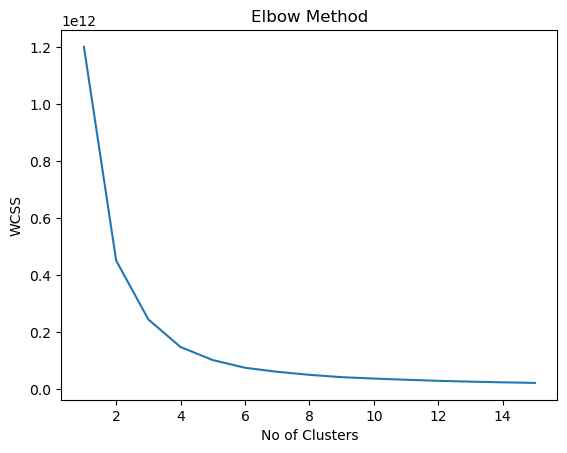

In [ ]:
wcss= [] #the sum of squared distance between each point and the centroid in a cluster
for i in range(1,16):
    k_means = KMeans(n_clusters=i, init="k-means++")
    k_means.fit(selected)
    wcss.append(k_means.inertia_)

plt.plot(range(1,16),wcss)
plt.title("Elbow Method")
plt.xlabel("No of Clusters")
plt.ylabel("WCSS")
plt.show()

#### After looking at the graph above we can observe that the elbow point is around 3 so the number of optimal clusters is 3. What's more, from different types of ELbow method I used inertia here.

### Silhouette_score

## For the optimal number of k both Elbow and Silhouette scoe should be taken into consideration
## Minus 5 points


In [ ]:
data_features = selected.iloc[:,:].values
silhouette_score(data_features,y_means)

0.6352091779071883

#### Silhouette_score can be in the range [-1,1]. Values close to 1 show that clustering has been successful on the other hand close to -1 the clustering is done poorly. And values close to 0 show that some point might apper near or on the boundaries. So our value of around 0.63 is not bad, while it could be improved.

#### 7.	Provide an interpretation of your findings regarding cluster size and characteristics of each cluster. For example, how clusters differ based on average monthly salary. (10 points)

In [ ]:
rfm_table

,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment,cluster
0,C37051,86,2,307,392.0,276.0,78.0,10.0,6.0,6.0,7.0,Leaving customers,0
1,C37054,2,46,23431,3438.0,3664.0,3562.0,84.0,86.0,86.0,85.0,Champions,2
2,C37057,61,11,5182,608.0,1818.0,1614.0,15.0,43.0,43.0,37.0,Risky customers,0
3,C37060,30,23,13406,1160.0,2854.0,2884.0,28.0,67.0,67.0,59.0,Potential Loyalists,0
4,C37063,6,2,1678,2698.0,276.0,550.0,66.0,6.0,6.0,18.0,Leaving customers,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271,C54853,121,4,2778,230.0,666.0,933.0,6.0,16.0,16.0,14.0,Leaving customers,0
4272,C54856,53,2,954,694.0,276.0,303.0,17.0,6.0,6.0,9.0,Leaving customers,0
4273,C54859,7,5,5526,2552.0,862.0,1703.0,63.0,20.0,20.0,29.0,Risky customers,0
4274,C54862,4,95,44223,3019.0,4126.0,4038.0,74.0,97.0,97.0,92.0,Champions,2


In [ ]:
pd.crosstab(rfm_updated['cluster'],rfm_updated['Gender'])

Gender,Female,Male
cluster,,
0,1589,1549
1,95,101
2,468,474


In [ ]:
rfm_updated.groupby('cluster')['Age', 'MonthlyIncome'].mean()

,Age,MonthlyIncome
cluster,,
0,50.444869,5738.746973
1,53.260204,5795.459184
2,49.571125,5741.281316


In [ ]:
rfm_table['cluster'].value_counts()

0    3138
2     942
1     196
Name: cluster, dtype: int64

### <u> Time for conclusions </u>

So we have 3 clusters among which the one labelled "0" is the greatest. They are similarly distributed among men and women and refer to people with close monthly incomes. However, we can also observe that these products are usually bought by people who are around 50.
